In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from data_preprocessing import *
from model import *

In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [4]:
x_train = training_data.text.apply(lambda x: preprocess_data(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: preprocess_data(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [5]:
y_train, y_val = label_encoder(y_train, y_val)

In [6]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [7]:
pad_len=100
padding_type='post'
truncating_type='post'

In [8]:
tokenizer, x_train_padded, x_val_padded = tokenizer_and_pad_training(x_train, 
                                                                     x_val, 
                                                                     pad_len, 
                                                                     padding_type, 
                                                                     truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-tokenizer-100.pk1")

In [9]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [10]:
vocab = tokenizer.word_index

In [11]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.ft.skipgram.mr.epoch50.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

51670
Total time taken:  4.874127977999999


(51791, 300)

In [12]:
input_dim = embedding_matrix1.shape[0]
embedding_dim = 300
input_len = pad_len
print("Input vocab: ", input_dim)
print("Embedding dimensions: ", embedding_dim)
print("Input sentence dimensions: ", input_len)

Input vocab:  51791
Embedding dimensions:  300
Input sentence dimensions:  100


In [13]:
myCB = myCallbacks(metrics='acc', threshold=0.95)

# Feed-Forward Neural Network Model

In [14]:
myDNN = create_model_DNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix1, 
                         input_len, 
                         trainable=False, 
                         n1=64, n2=32, 
                         kr=l2(0.015))
myDNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15537300  
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                19264     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 15,558,776
Trainable params: 21,476
Non-trainable params: 15,537,300
_________________________________________________________________


In [15]:
history1 = myDNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 10s 7ms/step - loss: 1.2216 - acc: 0.6958 - val_loss: 0.9129 - val_acc: 0.7468
Epoch 2/8
1313/1313 [==============================] - 10s 8ms/step - loss: 0.8562 - acc: 0.7543 - val_loss: 0.8302 - val_acc: 0.7553
Epoch 3/8
1313/1313 [==============================] - 10s 8ms/step - loss: 0.8079 - acc: 0.7598 - val_loss: 0.8314 - val_acc: 0.7357
Epoch 4/8
1313/1313 [==============================] - 10s 8ms/step - loss: 0.7817 - acc: 0.7607 - val_loss: 0.8037 - val_acc: 0.7447
Epoch 5/8
1313/1313 [==============================] - 9s 7ms/step - loss: 0.7649 - acc: 0.7622 - val_loss: 0.7656 - val_acc: 0.7659
Epoch 6/8
1313/1313 [==============================] - 11s 8ms/step - loss: 0.7463 - acc: 0.7670 - val_loss: 0.7244 - val_acc: 0.7865
Epoch 7/8
1313/1313 [==============================] - 11s 9ms/step - loss: 0.7386 - acc: 0.7681 - val_loss: 0.7399 - val_acc: 0.7585
Epoch 8/8
1313/1313 [==============================] - 10s 8ms/

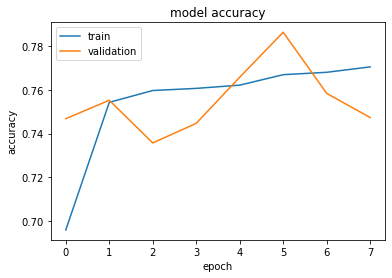

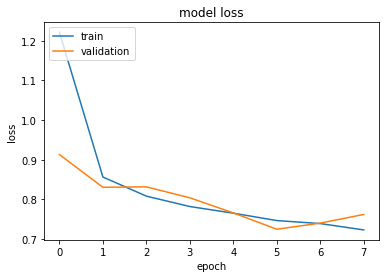

In [16]:
plot_curves(history1)

In [ ]:
name = "FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585"
myDNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myDNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myDNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myDNN = model_load("../models/FFNN/FFNN-n1.64-n2.32-kr0015-vacc8585.h5")

In [17]:
results1 = np.argmax(myDNN.predict(x_val_padded), axis=-1)

In [18]:
acc, precision, recall, f1 = classification_report(y_val, results1)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.7473544973544973

Precision:  [0.92957746 0.67242206 0.86757991 0.79393939]
Average Precision:  0.8158797074385113

Recall:  [0.47142857 0.93156146 0.6440678  0.67525773]
Average nRecall:  0.6805788904478809

F1-Score:  [0.62559242 0.7810585  0.73929961 0.72980501]
Average F1-Score:  0.7189388844264641


# CNN Model

In [19]:
myCNN = create_model_CNN(input_dim, 
                         embedding_dim, 
                         embedding_matrix1, input_len, 
                         trainable=False, 
                         n1=64, k=5, 
                         d=0.25, kr=l2(0.02))
myCNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          15537300  
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 64)            96064     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 15,633,624
Trainable params: 96,324
Non-trainable params: 15,537,300
_________________________________________________________________


In [20]:
history2 = myCNN.fit(x_train_padded, 
                     y_train, 
                     epochs=8, 
                     batch_size=32, 
                     verbose=1, 
                     validation_data = (x_val_padded, y_val), 
                     callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 48s 36ms/step - loss: 0.9394 - acc: 0.7994 - val_loss: 0.7450 - val_acc: 0.8370
Epoch 2/8
1313/1313 [==============================] - 49s 37ms/step - loss: 0.7814 - acc: 0.8223 - val_loss: 0.7587 - val_acc: 0.8307
Epoch 3/8
1313/1313 [==============================] - 45s 34ms/step - loss: 0.7856 - acc: 0.8233 - val_loss: 0.7810 - val_acc: 0.8278
Epoch 4/8
1313/1313 [==============================] - 49s 37ms/step - loss: 0.7814 - acc: 0.8251 - val_loss: 0.7683 - val_acc: 0.8283
Epoch 5/8
1313/1313 [==============================] - 50s 38ms/step - loss: 0.7812 - acc: 0.8252 - val_loss: 0.7414 - val_acc: 0.8434
Epoch 6/8
1313/1313 [==============================] - 55s 42ms/step - loss: 0.7795 - acc: 0.8256 - val_loss: 0.7894 - val_acc: 0.8230
Epoch 7/8
1313/1313 [==============================] - 50s 38ms/step - loss: 0.7866 - acc: 0.8250 - val_loss: 0.8642 - val_acc: 0.7918
Epoch 8/8
1313/1313 [==============================] - 

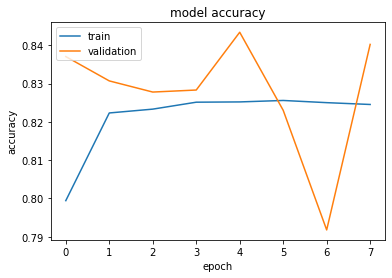

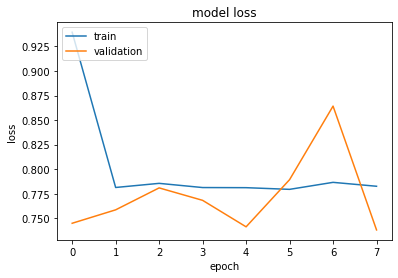

In [21]:
plot_curves(history2)

In [ ]:
name ="CNN/CNN-n1.64n2.64-kr0015-vacc8632"
myCNN.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myCNN.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myCNN.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myCNN = model_load("../models/CNN/CNN-n1.64n2.64-kr0015-vacc8632.h5")

In [22]:
results2 = np.argmax(myCNN.predict(x_val_padded), axis=-1)

In [23]:
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8402116402116402

Precision:  [0.83844011 0.83229036 0.87995198 0.82020202]
Average Precision:  0.8427211188421605

Recall:  [0.71666667 0.88372093 0.82824859 0.8371134 ]
Average nRecall:  0.8164373966329255

F1-Score:  [0.77278562 0.85723493 0.85331781 0.82857143]
Average F1-Score:  0.8279774491270031


# Bi-LSTM Model

In [14]:
myLSTM = create_model_LSTM(input_dim, 
                           embedding_dim, 
                           embedding_matrix1, 
                           input_len, 
                           trainable=False, 
                           n1=32, n2=32, 
                           d=0.25)
myLSTM.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          15537300  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 64)           85248     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 132       
Total params: 15,624,760
Trainable params: 87,460
Non-trainable params: 15,537,300
_________________________________________________________________


In [15]:
history3 = myLSTM.fit(x_train_padded, 
                      y_train, 
                      epochs=8, 
                      batch_size=32, 
                      verbose=1, 
                      validation_data = (x_val_padded, y_val), 
                      callbacks=[myCB])

Epoch 1/8
1313/1313 [==============================] - 174s 133ms/step - loss: 0.4873 - acc: 0.8191 - val_loss: 0.3872 - val_acc: 0.8587
Epoch 2/8
1313/1313 [==============================] - 179s 137ms/step - loss: 0.3778 - acc: 0.8597 - val_loss: 0.3592 - val_acc: 0.8680
Epoch 3/8
1313/1313 [==============================] - 190s 145ms/step - loss: 0.3435 - acc: 0.8732 - val_loss: 0.3488 - val_acc: 0.8675
Epoch 4/8
1313/1313 [==============================] - 210s 160ms/step - loss: 0.3206 - acc: 0.8816 - val_loss: 0.3559 - val_acc: 0.8619
Epoch 5/8
1313/1313 [==============================] - 180s 137ms/step - loss: 0.2984 - acc: 0.8881 - val_loss: 0.3406 - val_acc: 0.8730
Epoch 6/8
1313/1313 [==============================] - 209s 159ms/step - loss: 0.2806 - acc: 0.8941 - val_loss: 0.3395 - val_acc: 0.8722
Epoch 7/8
1313/1313 [==============================] - 231s 176ms/step - loss: 0.2651 - acc: 0.9006 - val_loss: 0.3345 - val_acc: 0.8730
Epoch 8/8
1313/1313 [====================

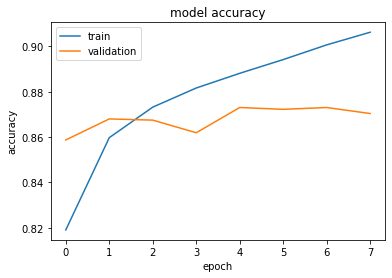

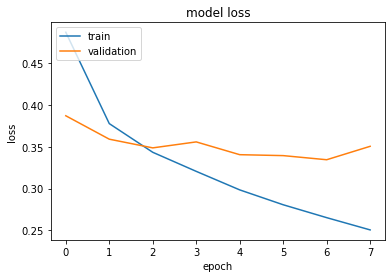

In [16]:
plot_curves(history3)

In [ ]:
name= "LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868"
myLSTM.save("../models/"+name+".h5")
# serialize model to JSON
model_json = myLSTM.to_json()
with open("../models/"+name+".json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
myLSTM.save_weights("../models/"+name+"_weights.h5")

In [ ]:
myLSTM = model_load("../models/LSTM/Bi-LST-n1.64-n2.64-kr0015-vacc868.h5")

In [18]:
results3 = np.argmax(myLSTM.predict(x_val_padded), axis=-1)

In [19]:
acc, precision, recall, f1 = classification_report(y_val, results3)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average nRecall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8703703703703703

Precision:  [0.89944134 0.87012156 0.93034826 0.81516588]
Average Precision:  0.8787692593415724

Recall:  [0.76666667 0.90365449 0.84519774 0.88659794]
Average nRecall:  0.8505292074934562

F1-Score:  [0.8277635  0.88657106 0.8857312  0.84938272]
Average F1-Score:  0.8623621175376339
